In [1]:
import os
import pandas as pd
import geopandas as gpd
import numpy as np
import xarray as xr
from datetime import datetime
from shapely.geometry import Point
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import cartopy
import cartopy.crs as ccrs
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

ERROR 1: PROJ: proj_create_from_database: Open of /dartfs-hpc/rc/home/0/f004260/.conda/envs/arg24/share/proj failed


In [2]:
root_dir = '/dartfs-hpc/rc/lab/C/CMIG'
project_dir = os.path.join(root_dir,'damages','county')

In [3]:
gdf = gpd.read_file(os.path.join(project_dir,'data','interim','cnty_bnds_fixed'))

In [4]:
lnd = pd.read_csv(os.path.join(project_dir,'data','raw','lnd_full_clean_2024-12-31.csv'))
lnd = lnd[lnd['weight_type']=='Population']
lnd = lnd[lnd['fips'].notnull()]
lnd['county'] = lnd['fips'].astype(int)
lnd['begin_date'] = pd.to_datetime(lnd['begin_date'])
lnd['year'] = lnd['begin_date'].dt.year
lnd['month'] = lnd['begin_date'].dt.month



In [5]:
import pickle
with open(os.path.join(project_dir,'data','interim','va_fips_crosswalk.pkl'),'rb') as src:
    va_crosswalk = pickle.load(src)

In [6]:
lnd['county'] = lnd['county'].replace(va_crosswalk)

In [7]:
cnty_dmg = lnd.groupby(['county','begin_date','disaster_group'])[['damages_total_adj']].sum() # sum damage
cnty_dmg_ds = xr.Dataset.from_dataframe(cnty_dmg).resample(begin_date='1ME').sum() # aggregrate to monthly scale
cnty_dmg_ds = cnty_dmg_ds.rename({"begin_date":"time"})

In [8]:
sep18 = lnd[(lnd['disaster_group']=='Flood')&(lnd['year']==2018)&(lnd['month']==9)&(lnd['damages_total_adj']>0)]
# sep18 = gdf.merge(sep18,on=['county'])
# sep18['geometry'] = sep18.geometry.unary_union

In [9]:
# FEMA disaster declarations 
dis_dec = pd.read_csv(os.path.join(project_dir,'data','raw','DisasterDeclarationsSummaries.csv'))
dis_dec = dis_dec[dis_dec['fipsCountyCode']!=0]
dis_dec['county'] = dis_dec['fipsStateCode'].astype(str)+dis_dec['fipsCountyCode'].astype(str).str.zfill(3)
dis_dec['county'] = dis_dec['county'].astype(int)
dis_dec['county'] = dis_dec['county'].replace(va_crosswalk)
dis_dec['incidentBeginDate'] = pd.to_datetime(dis_dec['incidentBeginDate'])
dis_dec['decl'] = 1
dis_dec = dis_dec[dis_dec['incidentBeginDate'].dt.year>=2003]
dis_dec['flood_decl'] = ((dis_dec['declarationTitle'].str.contains("FLOOD"))|(dis_dec['designatedIncidentTypes'].str.contains("F"))|(dis_dec['incidentType'].isin(['Hurricane','Tropical Storm']))).astype(int)
dis_dec['time'] = dis_dec['incidentBeginDate'].apply(lambda x: datetime(x.year,x.month,x.day))
dis_dec_ds = xr.Dataset.from_dataframe(dis_dec.groupby(['county','time'])[['flood_decl']].max()).resample(time='1ME').max().fillna(0)

In [10]:
dis_dec_sep18 = gdf[['county','geometry']].merge(dis_dec[(dis_dec['incidentBeginDate'].dt.year==2018)&(dis_dec['incidentBeginDate'].dt.month==9)&(dis_dec['flood_decl']==1)],on='county')

In [11]:
nfip = xr.open_dataset(os.path.join(project_dir,'data','interim','nfip_dmg_mon_county.nc'))
nfip_sep18 = nfip.sel(time='2018-09-30')
nfip_sep18_df = nfip_sep18.to_dataframe().reset_index()

In [12]:
usgs_flood = xr.open_dataset(os.path.join(project_dir,'data','interim','usgs_flood.nc'))
usgs_flood_coords = usgs_flood[['latitude','longitude']].to_dataframe()
usgs_flood_coords['geometry'] = usgs_flood_coords.apply(lambda row: Point(row['longitude'],row['latitude']),axis=1)
usgs_flood_coords = gpd.GeoDataFrame(usgs_flood_coords)
usgs_flood_coords = gpd.sjoin(gdf[['county','geometry']],usgs_flood_coords)
usgs_cnty_dict = dict(zip(usgs_flood_coords['site_no'],usgs_flood_coords['county']))
usgs_flood['county'] = (("site_no"),[usgs_cnty_dict[i] if i in usgs_cnty_dict.keys() else 0 for i in usgs_flood['site_no'].values])
usgs_flood_cnty = usgs_flood.groupby("county").max()
usgs_flood_cnty = usgs_flood_cnty.drop_sel(county=0)
usgs_flood_cnty = usgs_flood_cnty.rename({"peak_dt":"time"}).resample(time='1ME').max()

In [13]:
usgs_flood_sep18 = usgs_flood.sel(peak_dt='2018-09').max("peak_dt").to_dataframe().reset_index()
usgs_flood_sep18 = usgs_flood_sep18[usgs_flood_sep18['flood']]
usgs_flood_sep18['geometry'] = usgs_flood_sep18.apply(lambda row: Point(row['longitude'],row['latitude']),axis=1)
usgs_flood_sep18 = gpd.GeoDataFrame(usgs_flood_sep18)

In [14]:
rx_dir = os.path.join(project_dir,'data','processed','excess_precip_stats_mon','county')
cnty_rx = xr.open_dataset(os.path.join(rx_dir,'prism_clsm-grace_mon.nc'))
cnty_rx['tws_anom'] = cnty_rx['tws_def_ant']-cnty_rx['tws_def_ant'].mean('time')

cnty_rx['county'] = cnty_rx['county'].astype(int)
cnty_rx = xr.merge([cnty_rx,
                    cnty_dmg_ds.sel(disaster_group='Flood'),
                    usgs_flood_cnty,
                    dis_dec_ds,
                    nfip],join='outer')
cnty_rx_df = cnty_rx.to_dataframe().dropna(subset=['p_exc'])
cnty_rx_df['pexc_bin'] = pd.cut(cnty_rx_df['p_exc'],bins=np.arange(-1000,1051,50)-25)

In [15]:
(cnty_rx_df['damages_total_adj']>1e3).mean()

np.float64(0.034161359706465354)

In [16]:
(cnty_rx_df['claims']>10).mean()

np.float64(0.008201703354362705)

In [17]:
(cnty_rx_df['flood']==1).mean()

np.float64(0.024936304073314198)

In [18]:
(cnty_rx_df['flood_decl']).mean()

np.float64(0.026380009151304062)

In [19]:
cnty_rx_df['flood'] = ((cnty_rx_df['damages_total_adj']>1e3)|(cnty_rx_df['claims']>10)|(cnty_rx_df['flood_decl']==1)|(cnty_rx_df['flood']==1))
p_flood = cnty_rx_df['flood'].mean()
from scipy.stats import gaussian_kde
flood_pexc_kde = gaussian_kde(cnty_rx_df[cnty_rx_df['flood']]['p_exc'],bw_method=1.).pdf(np.arange(-1000,1001,10))
all_pexc_kde = gaussian_kde(cnty_rx_df['p_exc'],bw_method=1.).pdf(np.arange(-1000,1001,10))

In [20]:
(cnty_rx_df[cnty_rx_df['flood']==1]['tws_anom']<0).mean()


np.float64(0.6243818087497839)

In [21]:
grid_rx = xr.open_dataset(os.path.join(project_dir,'data','processed','excess_precip_stats_mon','grid','prism_clsm-grace_mon.nc'))

In [22]:
# import xesmf as xe
# grid_rx_files = [f.replace("mon/county","mon/grid") for f in rx_files]

# ref_ds = xr.open_dataset(grid_rx_files[0]).sel(time='2018-09')
# ens = [ref_ds]
# for f in grid_rx_files:
#     prod = f.split("/")[-1].split("_")[0]
#     with xr.open_dataset(f).sel(time='2018-09') as ds:
#         if prod=='cpc':
#             ens.append(ds)
#         else:
#             regridder = xe.Regridder(ds,ref_ds,'conservative')
#             ds_regrid = regridder(ds)
#             ds_regrid = ds_regrid.where(ref_ds.notnull())
#             ens.append(ds_regrid)
#     print(f)
# ens = xr.concat(ens,dim='product')

In [23]:
gdf['rep_dmg'] = False
gdf.loc[gdf['county'].isin(sep18['county']),'rep_dmg']=True

gdf['gage_flood'] = False
gdf.loc[gdf['county'].isin(usgs_flood_sep18['county']),'gage_flood']=True

gdf['fema_dec'] = False
gdf.loc[gdf['county'].isin(dis_dec_sep18['county']),'fema_dec']=True

gdf['nfip_claims'] = False
gdf.loc[gdf['county'].isin(nfip_sep18_df[nfip_sep18_df['claims']>5]['county']),'nfip_claims']=True

In [24]:
gdf_state = gdf.dissolve(by='state')

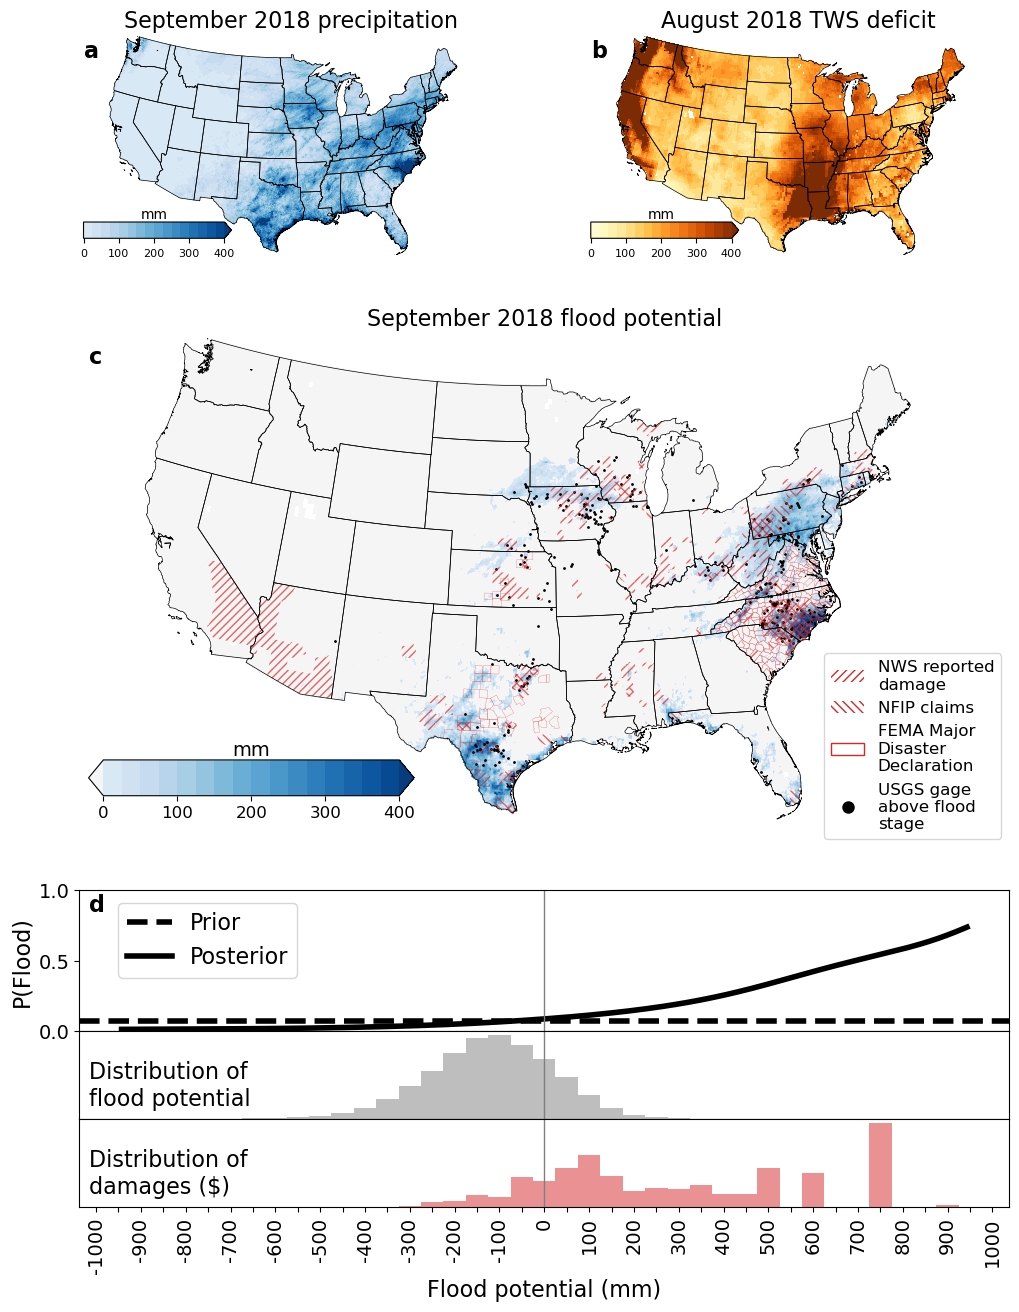

In [25]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
plt.rcParams.update({'font.size': 16,
                     'axes.labelsize':16})
plt.rc('xtick', labelsize=14) # Set x-axis tick label size
plt.rc('ytick', labelsize=14) # Set y-axis tick label size
levels = np.arange(0,401,25)
ppt_cols = sns.color_palette("Blues",len(levels)+2)
tws_cols = sns.color_palette("YlOrBr",len(levels))
ppt_cmap = mpl.colors.ListedColormap(ppt_cols[2:-1])
ppt_cmap.set_over(ppt_cols[-1])
ppt_cmap.set_under("whitesmoke")
tws_cmap = mpl.colors.ListedColormap(tws_cols[:-1])
tws_cmap.set_over(tws_cols[-1])

norm = plt.Normalize(vmin=0,vmax=400)
fp_norm = plt.Normalize(vmin=0,vmax=250)

fig = plt.figure(figsize=(12,16))
gs = gridspec.GridSpec(nrows=7,ncols=2,hspace=0,height_ratios=[1,0.75,0.75,0.1,2/5,1/4,1/4],figure=fig)
ax1 = plt.subplot(gs[0,0],projection=ccrs.AlbersEqualArea(central_longitude=-96,central_latitude=37.5,standard_parallels=(29.5, 45.5)))
grid_rx.sel(time='2018-09-30')['ppt'].plot(ax=ax1,cmap=ppt_cmap,norm=norm,transform=ccrs.PlateCarree(),add_colorbar=False)
ax1.title.set_text("")
ax1.text(0.5,1.01,"September 2018 precipitation",ha='center',va='bottom',transform=ax1.transAxes)
asp = ax1.get_aspect()

ax2 = plt.subplot(gs[0,1],projection=ccrs.AlbersEqualArea(central_longitude=-96,central_latitude=37.5,standard_parallels=(29.5, 45.5)))
grid_rx.sel(time='2018-09-30')['tws_def_ant'].plot(ax=ax2,cmap=tws_cmap,norm=norm,transform=ccrs.PlateCarree(),add_colorbar=False)
ax2.title.set_text('')
ax2.text(0.5,1.01,"August 2018 TWS deficit",ha='center',va='bottom',transform=ax2.transAxes)

ax3 = plt.subplot(gs[1:3,:],projection=ccrs.AlbersEqualArea(central_longitude=-96,central_latitude=37.5,standard_parallels=(29.5, 45.5)))
grid_rx.sel(time='2018-09-30')['p_exc'].plot(ax=ax3,cmap=ppt_cmap,norm=norm,transform=ccrs.PlateCarree(),add_colorbar=False)
usgs_flood_sep18.plot(ax=ax3,transform=ccrs.PlateCarree(),color='black',markersize=1)
gdf[(gdf['fema_dec']==True)].geometry.boundary.plot(ax=ax3,transform=ccrs.PlateCarree(),edgecolor='tab:red',lw=0.15,label='FEMA Major\nDisaster Declaration')
gdf[(gdf['rep_dmg']==True)].plot(ax=ax3,transform=ccrs.PlateCarree(),facecolor='none',edgecolor='tab:red',hatch='////',lw=0,alpha=0.7,label='Reported damage')
gdf[(gdf['nfip_claims']==True)].plot(ax=ax3,transform=ccrs.PlateCarree(),facecolor='none',edgecolor='tab:red',hatch='\\\\\\\\',lw=0,alpha=0.7,label='NFIP claims')
ax3.set_aspect(asp)
ax3.title.set_text("")
ax3.text(0.5,1.01,"September 2018 flood potential",ha='center',va='bottom',transform=ax3.transAxes)
leg_el = [Patch(facecolor='white',edgecolor='tab:red',hatch='////',lw=0,label='NWS reported\ndamage'),
          Patch(facecolor='white',edgecolor='tab:red',hatch='\\\\\\\\',lw=0,label='NFIP claims'),
          Patch(facecolor='white',edgecolor='tab:red',label='FEMA Major\nDisaster\nDeclaration'),
          Line2D([0], [0], marker='o', color='w',markerfacecolor='black', markersize=10,label='USGS gage\nabove flood\nstage')]
ax3.legend(handles=leg_el,loc='lower right',fontsize=12)
# leg_el = [Line2D([0], [0], marker='o', color='w', label='USGS gages\nw/ reported\nflooding',markerfacecolor='black', markersize=10),
          # Line2D([0], [0], marker='o', color='w', label='USGS gages w/o\nreported flooding',markerfacecolor='white',markeredgecolor='black', markersize=8),
          # Patch(facecolor='white',edgecolor='tab:red',label='Counties\nw/ reported\ndamage')]
# ax3.legend(handles=leg_el,loc='lower right',fontsize=14)
# ax3.legend(loc='lower right',fontsize=14)
# ax.coastlines("110m")
# ax.add_feature(cartopy.feature.LAND,color='tab:grey',alpha=0.5)
for ax in [ax1,ax2,ax3]:
    ax.set_extent([-123, -68, 24, 49],ccrs.PlateCarree())
    gdf_state.geometry.boundary.plot(ax=ax,transform=ccrs.PlateCarree(),edgecolor='black',lw=0.5)
    ax.set_aspect(asp)
    ax.set_frame_on(False)

cax1 = ax1.inset_axes([0.01,0.125,0.35,0.07])
ppt_cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm,cmap=ppt_cmap),cax=cax1,orientation='horizontal',ticks=[0,100,200,300,400,
                                                                                                               ],shrink=0.8,pad=0.05,extend='max',label='')
ppt_cbar.ax.tick_params(labelsize=8)
ppt_cbar.ax.text(0.5,1.01,'mm',ha='center',va='bottom',transform=ppt_cbar.ax.transAxes,fontsize=10)

# for l in ppt_cbar.ax.get_xticklabels()[1::2]:
    # l.set_visible(False)
    
cax2 = ax2.inset_axes([0.01,0.125,0.35,0.07])
tws_cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm,cmap=tws_cmap),cax=cax2,orientation='horizontal',ticks=[0,100,200,300,400,],shrink=0.8,pad=0.05,extend='max',label='')
tws_cbar.ax.tick_params(labelsize=8)
tws_cbar.ax.text(0.5,1.01,'mm',ha='center',va='bottom',transform=tws_cbar.ax.transAxes,fontsize=10)
# for l in tws_cbar.ax.get_xticklabels()[1::2]:
    # l.set_visible(False)
    
cax3 = ax3.inset_axes([0.01,0.1,0.35,0.07])
exc_cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm,cmap=ppt_cmap),cax=cax3,orientation='horizontal',ticks=[0,100,200,300,400],shrink=0.8,pad=0.05,extend='both')
exc_cbar.ax.tick_params(labelsize=12)
exc_cbar.ax.text(0.5,1.01,'mm',ha='center',va='bottom',transform=exc_cbar.ax.transAxes,fontsize=14)
# for l in exc_cbar.ax.get_xticklabels()[1::2]:
    # l.set_visible(False)
    
ax4 = plt.subplot(gs[4:5,:])
ax4.axhline(p_flood,color='black',lw=4,linestyle='--',label='Prior')
ax4.plot(np.arange(-1000,1001,10),p_flood*flood_pexc_kde/all_pexc_kde,color='black',lw=4,label='Posterior')
ax4.set_ylabel("P(Flood)")
ax4.set_ylim(0,1)
ax4.set_yticks([0,0.5,1])
ax4.legend(bbox_to_anchor=(0.03,0.99))

ax5 = plt.subplot(gs[5,:])
ax5.text(0.01,0.1,'Distribution of\nflood potential',ha='left',va='bottom',transform=ax5.transAxes)
(cnty_rx_df.groupby("pexc_bin")['p_exc'].count()/cnty_rx_df['p_exc'].count()).plot.bar(ax=ax5,width=1,color='tab:grey',alpha=0.5)
ax5.set_xticks([])
ax5.set_yticks([])
ax5.axvline(20,color='grey',lw=1)

ax6 = plt.subplot(gs[6,:])
ax6.text(0.01,0.1,'Distribution of\ndamages ($)',ha='left',va='bottom',transform=ax6.transAxes)
(cnty_rx_df.groupby("pexc_bin")['damages_total_adj'].sum()/cnty_rx_df['damages_total_adj'].sum()).plot.bar(ax=ax6,width=1,color='tab:red',alpha=0.5,label='Total damages')
ax4.set_xticks([])
ax6.set_xticklabels(np.arange(-1000,1051,50)[:-1])
for l in ax6.get_xticklabels()[1::2]:
    l.set_visible(False)
ax6.set_xlabel("Flood potential (mm)")
ax6.set_ylabel("")
ax6.set_yticks([])
ax4.axvline(0,color='grey',lw=1)
ax6.axvline(20,color='grey',lw=1)

labels = ['a','b','c','d']
for i,ax in enumerate([ax1,ax2,ax3,ax4]):
    ax.text(0.01,0.98,labels[i],ha='left',va='top',fontsize=16,fontweight='bold',transform=ax.transAxes)
plt.savefig(os.path.join(project_dir,'figures','main','fig1_flood.png'),bbox_inches='tight',dpi=350)
plt.savefig(os.path.join(project_dir,'figures','main','fig1_flood.pdf'),bbox_inches='tight',dpi=350)
plt.show()


In [ ]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
plt.rcParams.update({'font.size': 16,
                     'axes.labelsize':16})
plt.rc('xtick', labelsize=14) # Set x-axis tick label size
plt.rc('ytick', labelsize=14) # Set y-axis tick label size
levels = np.arange(0,501,25)
ppt_cols = sns.color_palette("Blues",len(levels)+2)
tws_cols = sns.color_palette("YlOrBr",len(levels))
ppt_cmap = mpl.colors.ListedColormap(ppt_cols[2:-1])
ppt_cmap.set_over(ppt_cols[-1])
ppt_cmap.set_under("whitesmoke")
tws_cmap = mpl.colors.ListedColormap(tws_cols[:-1])
tws_cmap.set_over(tws_cols[-1])

norm = plt.Normalize(vmin=0,vmax=500)
fp_norm = plt.Normalize(vmin=0,vmax=250)

fig = plt.figure(figsize=(12,12))
gs = gridspec.GridSpec(nrows=3,ncols=2,hspace=0,height_ratios=[1,0.8,0.8],figure=fig)
ax1 = plt.subplot(gs[0,0],projection=ccrs.AlbersEqualArea(central_longitude=-96,central_latitude=37.5,standard_parallels=(29.5, 45.5)))
grid_rx.sel(time='2018-09-30')['rain'].plot(ax=ax1,cmap=ppt_cmap,norm=norm,transform=ccrs.PlateCarree(),add_colorbar=False)
ax1.title.set_text("")
ax1.text(0.5,1.01,"September 2018 rainfall",ha='center',va='bottom',transform=ax1.transAxes)
asp = ax1.get_aspect()

ax2 = plt.subplot(gs[0,1],projection=ccrs.AlbersEqualArea(central_longitude=-96,central_latitude=37.5,standard_parallels=(29.5, 45.5)))
grid_rx.sel(time='2018-09-30')['tws_def_ant'].plot(ax=ax2,cmap=tws_cmap,norm=norm,transform=ccrs.PlateCarree(),add_colorbar=False)
ax2.title.set_text('')
ax2.text(0.5,1.01,"August 2018 TWS deficit",ha='center',va='bottom',transform=ax2.transAxes)

ax3 = plt.subplot(gs[1:,:],projection=ccrs.AlbersEqualArea(central_longitude=-96,central_latitude=37.5,standard_parallels=(29.5, 45.5)))
grid_rx.sel(time='2018-09-30')['p_exc'].plot(ax=ax3,cmap=ppt_cmap,norm=fp_norm,transform=ccrs.PlateCarree(),add_colorbar=False)
# usgs_flood_df[usgs_flood_df['flood']].plot(ax=ax3,transform=ccrs.PlateCarree(),color='black',markersize=1)
# gdf[(gdf['rep_dmg']==True)].plot(ax=ax3,transform=ccrs.PlateCarree(),facecolor='none',edgecolor='tab:red',hatch='////',lw=0,alpha=0.7,label='Reported damage')
# gdf[(gdf['nfip_claims']==True)].plot(ax=ax3,transform=ccrs.PlateCarree(),facecolor='none',edgecolor='tab:red',hatch='\\\\\\\\',lw=0,alpha=0.7,label='NFIP claims')
# gdf[(gdf['gage_flood']==True)].plot(ax=ax3,transform=ccrs.PlateCarree(),facecolor='none',edgecolor='tab:red',lw=0.2,label='Flooding at\nUSGS gage')
ax3.set_aspect(asp)
ax3.title.set_text("")
ax3.text(0.5,1.01,"September 2018 flood potential",ha='center',va='bottom',transform=ax3.transAxes)
# leg_el = [Patch(facecolor='white',edgecolor='tab:red',hatch='////',lw=0,label='NWS reported\ndamage'),
#           Patch(facecolor='white',edgecolor='tab:red',hatch='\\\\\\\\',lw=0,label='NFIP claims'),
#           Line2D([0], [0], marker='o', color='w',markerfacecolor='black', markersize=10,label='USGS gage\nabove flood\nstage')]
# ax3.legend(handles=leg_el,loc='lower right',fontsize=12)
# leg_el = [Line2D([0], [0], marker='o', color='w', label='USGS gages\nw/ reported\nflooding',markerfacecolor='black', markersize=10),
          # Line2D([0], [0], marker='o', color='w', label='USGS gages w/o\nreported flooding',markerfacecolor='white',markeredgecolor='black', markersize=8),
          # Patch(facecolor='white',edgecolor='tab:red',label='Counties\nw/ reported\ndamage')]
# ax3.legend(handles=leg_el,loc='lower right',fontsize=14)
# ax3.legend(loc='lower right',fontsize=14)
# ax.coastlines("110m")
# ax.add_feature(cartopy.feature.LAND,color='tab:grey',alpha=0.5)
for ax in [ax1,ax2,ax3]:
    ax.set_extent([-123, -68, 24, 49],ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.STATES,edgecolor='black',lw=0.5)
    
cax1 = ax1.inset_axes([0.01,0.125,0.35,0.07])
ppt_cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm,cmap=ppt_cmap),cax=cax1,orientation='horizontal',ticks=[0,100,200,300,400,500],shrink=0.8,pad=0.05,extend='max',label='')
ppt_cbar.ax.tick_params(labelsize=8)
ppt_cbar.ax.text(0.5,1.01,'mm',ha='center',va='bottom',transform=ppt_cbar.ax.transAxes,fontsize=10)

# for l in ppt_cbar.ax.get_xticklabels()[1::2]:
    # l.set_visible(False)
    
cax2 = ax2.inset_axes([0.01,0.125,0.35,0.07])
tws_cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm,cmap=tws_cmap),cax=cax2,orientation='horizontal',ticks=[0,100,200,300,400,500],shrink=0.8,pad=0.05,extend='max',label='')
tws_cbar.ax.tick_params(labelsize=8)
tws_cbar.ax.text(0.5,1.01,'mm',ha='center',va='bottom',transform=tws_cbar.ax.transAxes,fontsize=10)
# for l in tws_cbar.ax.get_xticklabels()[1::2]:
    # l.set_visible(False)
    
cax3 = ax3.inset_axes([0.01,0.125,0.35,0.07])
exc_cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=fp_norm,cmap=ppt_cmap),cax=cax3,orientation='horizontal',ticks=[0,50,100,150,200,250],shrink=0.8,pad=0.05,extend='both')
exc_cbar.ax.tick_params(labelsize=12)
exc_cbar.ax.text(0.5,1.01,'mm',ha='center',va='bottom',transform=exc_cbar.ax.transAxes,fontsize=14)
# for l in exc_cbar.ax.get_xticklabels()[1::2]:
    # l.set_visible(False)
    
# ax4 = plt.subplot(gs[3:5,:])
# ax4.axhline(p_flood,color='black',lw=4,linestyle='--',label='Prior')
# ax4.plot(np.arange(-1000,1001,10),p_flood*flood_pexc_kde/all_pexc_kde,color='black',lw=4,label='Posterior')
# ax4.set_ylabel("P(Flood)")
# ax4.legend(bbox_to_anchor=(0.03,0.99))

# # ax5 = plt.subplot(gs[4,:])
# ax6 = plt.subplot(gs[5,:])
# ax6.text(0.01,0.1,'Distribution of\ndamages ($)',ha='left',va='bottom',transform=ax6.transAxes)
# (cnty_rx_df.groupby("pexc_bin")['damages_total_adj'].sum()/cnty_rx_df['damages_total_adj'].sum()).plot.bar(ax=ax6,width=1,color='tab:red',alpha=0.5,label='Total damages')
# ax4.set_xticks([])
# # ax5.set_xticks([])
# ax6.set_xticklabels(np.arange(-1000,1051,50)[:-1])
# for l in ax6.get_xticklabels()[1::2]:
#     l.set_visible(False)
# ax6.set_xlabel("Flood potential (mm)")
# ax6.set_ylabel("")
# # ax4.set_yticks([])
# # ax5.set_yticks([])
# ax6.set_yticks([])
    
# labels = ['a','b','c','d']
# for i,ax in enumerate([ax1,ax2,ax3,ax4]):
#     ax.text(0.01,0.98,labels[i],ha='left',va='top',fontsize=16,fontweight='bold',transform=ax.transAxes)
# plt.savefig(os.path.join(project_dir,'figures','main','fig1_flood.png'),bbox_inches='tight',dpi=350)
# plt.savefig(os.path.join(project_dir,'figures','main','fig1_flood.pdf'),bbox_inches='tight',dpi=350)
# plt.show()


In [ ]:
(cnty_rx_df.groupby("pexc_bin")['damages_total_adj'].sum()/cnty_rx_df['damages_total_adj'].sum())